# TROP on the example dataset

This notebook shows how to run the TROP estimator from the packaged implementation on the Penn dataset.

It covers:

- How to load and shape the Penn panel into `(N, T)` form.
- How to construct a simple treatment indicator matrix `W` consistent with the replication scripts.
- A quick overview of the TROP objective and its tuning parameters:  
  `lambda_unit`, `lambda_time`, `lambda_nn`.
- How to tune these parameters using placebo cross-validation on the control-only subpanel.

## 1. Setup

### Install 

If you are running this from a clean environment, install the package and its dependencies:

```bash
pip install trop
```

### Import

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

np.random.seed(0)

# Import the TROP package
from trop import TROP_TWFE_average, TROP_cv_single, TROP_cv_cycle, TROP_cv_joint

## 2. Load the Penn panel and build `(N, T)` arrays

The replication scripts treat `PENN.csv` as a balanced panel with:

- `T = 48` years (1960–2007)
- `N = 111` countries

The file is arranged year-major: all countries for a given year, then the next year, etc.

The helper below replicates the transformation used in the provided scripts:
- reshape to `(T, N)` then transpose to `(N, T)`.
- standardize the outcome: divide by its overall standard deviation, then de-mean.

In [2]:
DATA_PATH = Path("data/PENN.csv")

def load_penn_panel(
    outcome: str = "log_gdp",
    treatment: str = "dem",
    data_path: Path = DATA_PATH,
) -> dict:
    '''
    Load PENN.csv and return a dict with:
      - Y: (N, T) outcome matrix
      - D: (N, T) boolean treatment matrix from the raw column (e.g., 'dem')
      - assignment_vector: (N,) indicator of whether a unit is ever-treated in D
      - countries: list[str] length N (row labels)
      - years: list[int] length T (column labels)
    '''
    if not data_path.exists():
        raise FileNotFoundError(
            f"Could not find {data_path.resolve()}. "
            "Put PENN.csv next to the notebook or update DATA_PATH."
        )

    df = pd.read_csv(data_path, sep=";")

    years = sorted(df["year"].unique().tolist())
    T = len(years)

    # country ordering
    countries = df.loc[df["year"] == years[0], "country"].tolist()
    N = len(countries)

    # Replication reshape
    Y = np.reshape(df[outcome].values, (T, -1)).T.astype(float)
    D = np.reshape(df[treatment].values, (T, -1)).T.astype(bool)

    # Standardize outcome
    Y = Y / np.std(Y)
    Y = Y - np.mean(Y)

    # Ever-treated indicator
    Ds = np.argwhere(D == True)[:, 0]
    assignment_vector = np.zeros((N,), dtype=int)
    assignment_vector[Ds] = 1

    return {
        "Y": Y,
        "D": D,
        "assignment_vector": assignment_vector,
        "countries": countries,
        "years": years,
    }

penn = load_penn_panel(outcome="log_gdp", treatment="dem")
Y = penn["Y"]
D_raw = penn["D"]
assignment = penn["assignment_vector"]
countries = np.array(penn["countries"])
years = np.array(penn["years"])

N, T = Y.shape
n_treated_units = int(assignment.sum())
n_controls = int((assignment == 0).sum())

print(f"Y shape: {Y.shape} (N units x T periods)")
print(f"Treated units (ever-treated in raw D): {n_treated_units}")
print(f"Control units (never-treated in raw D): {n_controls}")
print(f"Years: {years.min()}–{years.max()} (T={T})")

Y shape: (111, 48) (N units x T periods)
Treated units (ever-treated in raw D): 29
Control units (never-treated in raw D): 82
Years: 1960–2007 (T=48)


### Wrap `Y` in a labeled DataFrame

This can make it easier to sanity-check the data.

In [3]:
Y_df = pd.DataFrame(Y, index=countries, columns=years)
D_df = pd.DataFrame(D_raw.astype(int), index=countries, columns=years)

display(Y_df.head())
display(D_df.head())

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
Argentina,0.459565,0.472985,0.465061,0.420462,0.470667,0.532111,0.521764,0.532993,0.563534,0.625232,...,0.793367,0.754941,0.738903,0.691537,0.584976,0.647053,0.710737,0.773197,0.829573,0.893544
Australia,0.945638,0.937950,0.973811,1.012899,1.048132,1.050276,1.085085,1.111744,1.153944,1.194163,...,1.637364,1.661018,1.668190,1.692356,1.708161,1.731681,1.747457,1.758828,1.776253,1.791384
Austria,0.637185,0.675559,0.687001,0.717799,0.761884,0.778395,0.818241,0.838914,0.870268,0.919760,...,1.563039,1.591436,1.617518,1.625162,1.635160,1.638775,1.657305,1.672238,1.697689,1.725785
Burundi,-1.749135,-1.902008,-1.853043,-1.817452,-1.786339,-1.768153,-1.756531,-1.664568,-1.684714,-1.714763,...,-1.600755,-1.621742,-1.645554,-1.648216,-1.634669,-1.670885,-1.663649,-1.683810,-1.667511,-1.667726
Belgium,0.627998,0.665283,0.703995,0.733969,0.783546,0.805141,0.824501,0.852002,0.887212,0.935857,...,1.510903,1.538943,1.566818,1.570604,1.581740,1.583850,1.609014,1.621129,1.636202,1.658591


,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
Argentina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Australia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Austria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Burundi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Belgium,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 3. Construct the treatment indicator `W

Thee treatment is implemented as:

- pick a set of treated units `treated_units`
- set `W[treated_units, -treated_periods:] = 1`

The treatment is a tail block affecting the last `treated_periods` years, for those selected units.

Below is the file convention:
- treated units = countries that are ever-treated in the raw `dem` indicator
- post-treatment block = last `treated_periods` years

In [4]:
treated_periods = 10

treated_units = np.where(assignment == 1)[0]
control_units = np.where(assignment == 0)[0]

W = np.zeros((N, T), dtype=float)
W[treated_units, -treated_periods:] = 1.0

post_years = years[-treated_periods:]
print("Post-treatment years:", post_years.tolist())
print("Number treated units:", treated_units.size)

print("Fraction treated cells in W:", W.mean())

Post-treatment years: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]
Number treated units: 29
Fraction treated cells in W: 0.05442942942942943


## 4. Overview of the TROP estimator

TROP estimates an average treatment effect parameter `τ` from a weighted two-way fixed effects objective, with an optional low-rank adjustment.

### Objective

Let:
- `Y` be the outcome matrix `(N × T)`
- `W` be the treatment indicator matrix `(N × T)`
- `α_i` unit fixed effects, `γ_t` time fixed effects, `μ` intercept
- `L` an optional low-rank component (matrix) with nuclear-norm regularization

TROP solves (schematically):

$$
\min_{\mu,\alpha,\gamma,\tau, L}
\;
\sum_{i,t} \delta_{it}
\Big( Y_{it} - \mu - \alpha_i - \gamma_t - \tau W_{it} - L_{it} \Big)^2
\;+\;
\lambda_{nn}\,\lVert L \rVert_*
$$

where the weights factorize into:

$$
\delta_{it}
=
\exp\!\big(-\lambda_{unit}\,\text{dist\_unit}(i)\big)
\cdot
\exp\!\big(-\lambda_{time}\,\text{dist\_time}(t)\big)
$$

- `dist_unit(i)` measures how dissimilar unit *i* is from the average treated pre-treatment trajectory.
- `dist_time(t)` measures how far time *t* is from the center of the treated tail block.

The reported estimate is the optimized value of `τ`.

### What the tuning parameters do

- **`lambda_unit` (≥ 0):** controls how aggressively you downweight “dissimilar” control units.  
  - `0` → uniform unit weighting.  
  - larger → concentrate weight on nearest neighbors to the treated trajectory (in pre-periods).

- **`lambda_time` (≥ 0):** controls how aggressively you downweight time periods far from the treated block.  
  - `0` → uniform over time.  
  - larger → concentrate weight around the treated/post block.

- **`lambda_nn` (≥ 0 or `np.inf`):** nuclear norm penalty on the low-rank component `L`.  
  - `np.inf` → **disable** the low-rank adjustment (pure weighted TWFE).  
  - finite positive values → allow a low-rank `L` to soak up latent factor structure.  
  - very large values → push `L → 0` (back toward weighted TWFE).

Because `lambda_unit` uses distances computed from `Y`, the scale of `Y` matters. Standardizing `Y` (as above) makes `lambda_unit` values more comparable across outcomes.

## 5. Run TROP on Penn dataset

If you have hand-tuned parameters from a paper/replication table, this is the simplest workflow:
1. load `Y`
2. construct `W` and `treated_units`
3. run `TROP_TWFE_average(...)`

Below we show:
- a “weighted TWFE only” run (`lambda_nn = np.inf`)
- a “low-rank + weights” run with finite `lambda_nn`

In [5]:
# Example 1: weighted TWFE only
tau_wtwfe = TROP_TWFE_average(
    Y=Y,
    W=W,
    treated_units=treated_units,
    lambda_unit=0.0,
    lambda_time=0.0,
    lambda_nn=np.inf,
    treated_periods=treated_periods,
    solver="OSQP",
    verbose=False,
)

# Example 2: weights + low-rank adjustment
tau_trop = TROP_TWFE_average(
    Y=Y,
    W=W,
    treated_units=treated_units,
    lambda_unit=0.3,
    lambda_time=0.325,
    lambda_nn=0.016,
    treated_periods=treated_periods,
    solver="SCS",
    verbose=False,
)

# Example 3: No distance weights, but with low-rank adjustment
tau_mc = TROP_TWFE_average(
    Y=Y,
    W=W,
    treated_units=treated_units,
    lambda_unit=0.0,
    lambda_time=0.0,
    lambda_nn=0.6,
    treated_periods=treated_periods,
    solver="SCS",
    verbose=False,
)
print("Estimated tau (weighted TWFE only):", tau_wtwfe)
print("Estimated tau (TROP: weights + low-rank):", tau_trop)
print("Estimated tau (MC-style: no weights, low-rank):", tau_mc)

Estimated tau (weighted TWFE only): 0.2217182353059236
Estimated tau (TROP: weights + low-rank): 0.03462771034557601
Estimated tau (MC-style: no weights, low-rank): 0.0631184409647811


## 6. Tuning the parameters via placebo cross-validation

The functions `TROP_cv_single`, `TROP_cv_cycle`, and `TROP_cv_joint` implement a placebo CV idea:

- Use a control-only panel `Y_control`.
- For each candidate tuning parameter value:
  - repeatedly assign a placebo treatment to random units for the last `treated_periods` columns
  - compute the placebo TROP estimate `\hat\tau`
- Since the placebo treatment has true effect 0, a good tuning parameter should make the placebo estimates small on average.

The CV score is the RMSE of placebo estimates:

$$
\text{score}(\lambda)
=
\sqrt{\mathbb{E}\!\left[\hat{\tau}(\lambda)^2\right]}
$$

### Practical guidance

- Start with small grids and small `n_trials` to validate the pipeline.
- Increase `n_trials` and refine grids once everything runs.
- For speed, use `n_jobs=-1` to parallelize placebo trials.

In [6]:
Y_control = Y[control_units, :]

n_placebo_treated = min(len(treated_units), Y_control.shape[0] - 1)
print("Placebo treated units per trial:", n_placebo_treated)

# Candidate grids
unit_grid = np.linspace(0.0, 1.5, 7)                        # lambda_unit
time_grid = np.linspace(0.0, 1.0, 6)                        # lambda_time
nn_grid = np.array([0.001, 0.005, 0.01, 0.02, 0.05, 0.1])   # lambda_nn

# Coordinate-descent tuning
l_unit, l_time, l_nn = TROP_cv_cycle(
    Y_control=Y_control,
    n_treated_units=n_placebo_treated,
    treated_periods=treated_periods,
    unit_grid=unit_grid,
    time_grid=time_grid,
    nn_grid=nn_grid,
    lambdas_init=None,
    max_iter=20,
    n_trials=50,
    n_jobs=-1,
    prefer="threads",
    random_seed=0,
    solver="SCS",
    verbose=False,
)

print("Selected lambdas (cycle CV):")
print("  lambda_unit =", l_unit)
print("  lambda_time =", l_time)
print("  lambda_nn   =", l_nn)

Placebo treated units per trial: 29
Selected lambdas (cycle CV):
  lambda_unit = 0.25
  lambda_time = 0.2
  lambda_nn   = 0.02


### Re-estimate `τ` using the tuned parameters

In [7]:
tau_tuned = TROP_TWFE_average(
    Y=Y,
    W=W,
    treated_units=treated_units,
    lambda_unit=l_unit,
    lambda_time=l_time,
    lambda_nn=l_nn,
    treated_periods=treated_periods,
    solver="SCS",
    verbose=False,
)

print("Estimated tau (TROP with placebo-CV tuned lambdas):", tau_tuned)

Estimated tau (TROP with placebo-CV tuned lambdas): 0.038239346879800705


### Joint grid search CV

If your grids are small, you can do a full joint search over
`unit_grid × time_grid × nn_grid`:

- Pros: global search over the discrete grid
- Cons: can be expensive (`len(grid)^3 × n_trials` optimizations)

This is useful as a robustness check once the pipeline is working.

In [ ]:
# This can be slow if grids are large
best_unit, best_time, best_nn = TROP_cv_joint(
    Y_control=Y_control,
    n_treated_units=n_placebo_treated,
    treated_periods=treated_periods,
    unit_grid=unit_grid,
    time_grid=time_grid,
    nn_grid=nn_grid,
    n_trials=25,
    n_jobs=-1,
    prefer="threads",
    random_seed=0,
    solver="SCS",
    verbose=False,
)

print("Selected lambdas (joint CV):", (best_unit, best_time, best_nn))

## 7. Simple sensitivity check

A good quick check is:
- hold `(lambda_unit, lambda_time)` fixed
- vary `lambda_nn` over a grid
- plot the resulting `τ`

If `τ` is extremely sensitive to small changes in `lambda_nn`, consider refining the CV grid or increasing `n_trials`.

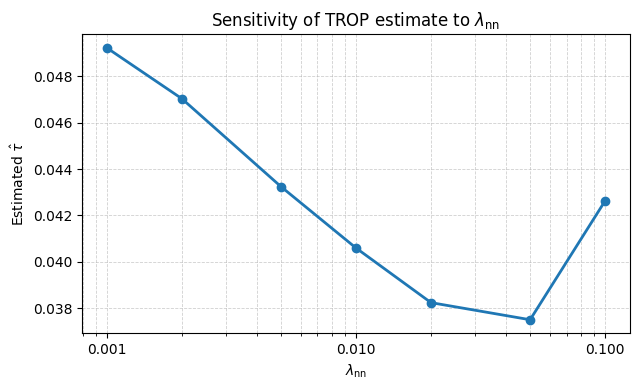

In [8]:
# Sensitivity over lambda_nn with unit/time fixed at tuned values

nn_grid_sens = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1])

taus = []
for lam in nn_grid_sens:
    tau_val = TROP_TWFE_average(
        Y=Y,
        W=W,
        treated_units=treated_units,
        lambda_unit=l_unit,
        lambda_time=l_time,
        lambda_nn=float(lam),
        treated_periods=treated_periods,
        solver="SCS",
        verbose=False,
    )
    taus.append(tau_val)

fig, ax = plt.subplots(figsize=(6.5, 4))

ax.plot(nn_grid_sens, taus, marker="o", linewidth=2)
ax.set_xscale("log")
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel(r"$\lambda_{\mathrm{nn}}$")
ax.set_ylabel(r"Estimated $\hat{\tau}$")
ax.set_title(r"Sensitivity of TROP estimate to $\lambda_{\mathrm{nn}}$")
ax.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)
fig.tight_layout()
plt.show()

## 8. Notes

`treated_periods` enters the estimator in two places:

* defines the pre-period window for unit-distance weighting
* sets the center for time-distance weighting near the post block

So it should match how you construct `W`. If your design changes, revisit this choice.

### Runtime

Placebo CV is expensive. Practical workflow:

* start with coarse grids and small `n_trials`
* scale up `n_trials` after debugging
* use `n_jobs=-1`
* prefer `TROP_cv_cycle` before a full `TROP_cv_joint` grid

### Interpretation

`tau` is in standardized units if you standardize `Y`. For original units, don’t standardize.

### Avoid `lambda_nn = 0`

With `lambda_nn=0`, the low-rank term `L` is unpenalized and can soak up residual variation, making `tau` weakly identified / solver-dependent. Use `lambda_nn > 0`.